In [1]:
# AA228 Orbital Rendezvous – Results & Analysis
# Author: Sabrina Nicacio
# This notebook uses the closed-loop rendezvous simulation from `systems.py`


import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
import pickle
from pprint import pprint

from systems import run_closed_loop_episode
import json
from dataclasses import dataclass

# Basic Setup

In [2]:
DEFAULT_CONFIG = {
    # --- simulation setup ---
    "dt": 1.0,                     # [s] simulation time step
    "N": 600,                      # number of time steps (horizon = N * dt secs) Can make it longer for better results
    "initial_state": (0,0,0,0,0,0),  # 6-state vector [x,y,z,xdot,ydot,zdot]

    # --- process / measurement noise scales (for Q and R) ---
    "sigma_pos": 10.0,             # [m] (not used directly here)
    "sigma_vel": 0.1,              # [m/s]
    "sigma_accel": 0.01,           # [m/s^2]
    "mean_motion": 0.0011,         # [rad/s] HCW mean motion n

    "sigma_accel_truth": 5e-4,     # [m/s^2] accel noise std for TRUE process noise Q
    "sigma_accel_model": 2e-5,     # [m/s^2] accel noise std for EKF model Q
    "sigma_meas_pos": 5.0,         # [m] per-axis position noise std for EKF R

    # --- initial state and belief (EKF) ---
    "x0_true": (10.0, 20.0, 22.0, 0.0, 0.0, 0.0),  # start ~50 m away
    "x0_hat_offset": (10.0, -5.0, -10.0, -0.2, 0.1, 0.9),
    "P0_diag": (10.0, 10.0, 10.0, 1.0, 1.0, 1.0),

    # --- reward shaping for the POMDP / MCTS ---
    # See reward function later in the code
    "reward": {
        "w_pos": 5.0,          # weight on ||position||^2
        "w_vel": 1,           # STRONGER weight on ||velocity||^2 to avoid huge speeds
        "w_u": 1e-6,            # weight on ||u||^2 for input
        "dock_bonus": 3000.0,  # big bonus when inside docking tolerances
        "dock_tol_pos": 2.0,    # [m]
        "dock_tol_vel": 0.2,   # [m/s]
        "v_impact_thresh": 1.0, # [m/s] inside tol_pos but faster than this → crash
        "big_crash_penalty": 5000.0,
        "alpha": 200.0,           # weight on progress term (prev_dist - new_dist)
    },

    "n_actions": 13
}

In [3]:
# Updating

CONFIG = {**DEFAULT_CONFIG, **{

    # --- initial state and belief (EKF) ---
    "x0_true": (10.0, 25.0, 22.0, 0.0, 0.0, 0.0),  # start ~50 m away
    "x0_hat_offset": (10.0, -5.0, -10.0, -0.2, 0.1, 0.9),
    "P0_diag": (10.0, 10.0, 10.0, 1.0, 1.0, 1.0),
}}
config_hash = json.dumps(CONFIG, sort_keys=True)

In [4]:
CONFIG

{'dt': 1.0,
 'N': 600,
 'initial_state': (0, 0, 0, 0, 0, 0),
 'sigma_pos': 10.0,
 'sigma_vel': 0.1,
 'sigma_accel': 0.01,
 'mean_motion': 0.0011,
 'sigma_accel_truth': 0.0005,
 'sigma_accel_model': 2e-05,
 'sigma_meas_pos': 5.0,
 'x0_true': (10.0, 25.0, 22.0, 0.0, 0.0, 0.0),
 'x0_hat_offset': (10.0, -5.0, -10.0, -0.2, 0.1, 0.9),
 'P0_diag': (10.0, 10.0, 10.0, 1.0, 1.0, 1.0),
 'reward': {'w_pos': 5.0,
  'w_vel': 1,
  'w_u': 1e-06,
  'dock_bonus': 3000.0,
  'dock_tol_pos': 2.0,
  'dock_tol_vel': 0.2,
  'v_impact_thresh': 1.0,
  'big_crash_penalty': 5000.0,
  'alpha': 200.0},
 'n_actions': 13}

In [5]:
def create_sphere(x_center, y_center, z_center, radius, resolution=50):
    """
    Returns the coordinates for plotting a sphere centered at (x_center, y_center, z_center).
    """
    # Create a grid of theta (longitude) and phi (latitude) angles
    u, v = np.mgrid[0:2*np.pi:resolution*1j, 0:np.pi:resolution*1j]
    
    # Calculate Cartesian coordinates
    x = radius * np.cos(u) * np.sin(v) + x_center
    y = radius * np.sin(u) * np.sin(v) + y_center
    z = radius * np.cos(v) + z_center
    
    return x, y, z

# Define sphere parameters
center = (0, 0, 0)
radius = CONFIG["reward"]["dock_tol_pos"]
x_coords, y_coords, z_coords = create_sphere(center[0], center[1], center[2], radius)

# Create the figure
fig = go.Figure(data=[])

In [6]:


plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["font.size"] = 12

dt = CONFIG["dt"]
N = CONFIG["N"]
t = np.arange(N + 1) * dt

dock_pos_tol = CONFIG["reward"]["dock_tol_pos"]
dock_vel_tol = CONFIG["reward"]["dock_tol_vel"]

def compute_metrics(res, seed):
    X_true = res["X_true"]          # (N+1, 6)
    X_hat = res["X_hat"]          # (N+1, 6)
    rewards = res["rewards"]        # (N,)
    actions = res["actions"]        # (N,)
    pos_norm = np.linalg.norm(X_true[:, :3], axis=1)
    vel_norm = np.linalg.norm(X_true[:, 3:], axis=1)

    final_dist = pos_norm[-1]
    min_dist = np.min(pos_norm)
    min_dist_step = np.argmin(pos_norm)
    min_dist_time = min_dist_step * dt

    cum_reward = np.cumsum(rewards)
    total_reward = cum_reward[-1]

    # docking condition: within both pos and vel tolerance
    dock_mask = (pos_norm <= dock_pos_tol) & (vel_norm <= dock_vel_tol)
    docked = np.any(dock_mask)
    dock_step = np.where(dock_mask)[0][0] if docked else CONFIG["N"]
    dock_time = dock_step * dt if docked else None

    return {
        "pos_norm": pos_norm,
        "vel_norm": vel_norm,
        "cum_reward": cum_reward,
        "final_dist": final_dist,
        "min_dist": min_dist,
        "min_dist_time": min_dist_time,
        "total_reward": total_reward,
        "docked": docked,
        "dock_step": dock_step,
        "dock_time": dock_time,

        "seed": seed,
        "X_true": X_true,
        "X_hat": X_hat,
        "rewards": rewards,
        "actions": actions
    }

def print_metrics(metrics, title="Episode metrics"):
    print(f"=== {title} ===")
    print(f"Final distance to target: {metrics['final_dist']:.3f} m")
    print(f"Minimum distance to target: {metrics['min_dist']:.3f} m "
          f"(at t = {metrics['min_dist_time']:.1f} s)")
    print(f"Total reward: {metrics['total_reward']:.3f}")
    if metrics["docked"]:
        print(f"Docked: YES at t = {metrics['dock_time']:.1f} s "
              f"(step {metrics['dock_step']})")
    else:
        print("Docked: NO (never simultaneously inside pos & vel tolerances)")
    print()





# Initial Run

In [63]:

# run a single "baseline" episode
seed = 42   # can change this and re-run
res = run_closed_loop_episode(CONFIG, seed=seed)




metrics = compute_metrics(res, seed)
dock_step = metrics['dock_step']

X_true = res["X_true"][:dock_step]
X_hat = res["X_hat"][:dock_step]
actions = res["actions"][:dock_step]
rewards = res["rewards"][:dock_step]

t = np.arange(dock_step) * dt

print_metrics(metrics, title=f"Episode (seed={seed})")

Created simulation lasting 600.00 sec (10.00 min) with 600 steps
[DEBUG] k=0, x = 34.77427030043216 m, u_x = +0.000e+00 m/s^2, x_next =   10.000 m, a_k = 3, r =   -0.719
[DEBUG] k=10, x = 34.20767037716373 m, u_x = +0.000e+00 m/s^2, x_next =    9.932 m, a_k = 5, r =   15.605
[DEBUG] k=20, x = 33.0549416768389 m, u_x = +0.000e+00 m/s^2, x_next =    9.506 m, a_k = 11, r =   32.651
[DEBUG] k=30, x = 30.980840280999526 m, u_x = +0.000e+00 m/s^2, x_next =    9.033 m, a_k = 10, r =   58.039
[DEBUG] k=40, x = 27.178976801970602 m, u_x = +0.000e+00 m/s^2, x_next =    8.348 m, a_k = 12, r =   88.823
[DEBUG] k=50, x = 21.555440024027135 m, u_x = +0.000e+00 m/s^2, x_next =    7.621 m, a_k = 10, r =  133.525
[DEBUG] k=60, x = 13.76956683218705 m, u_x = +0.000e+00 m/s^2, x_next =    6.661 m, a_k = 12, r =  167.050
[DEBUG] k=70, x = 5.620932743613384 m, u_x = +0.000e+00 m/s^2, x_next =    5.144 m, a_k = 6, r =  123.824
[DEBUG] k=80, x = 7.8003665682330015 m, u_x = +0.000e+00 m/s^2, x_next =    3.266

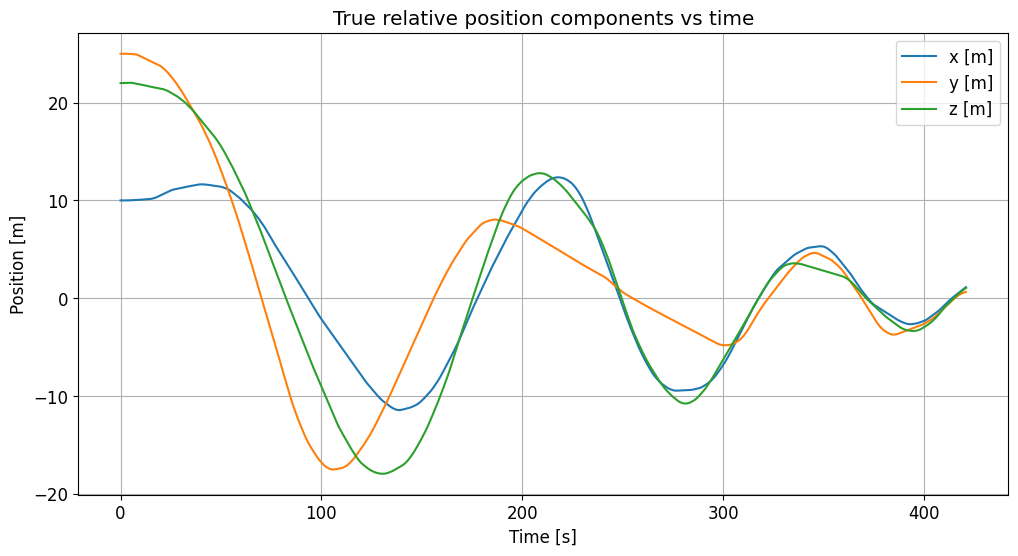

In [22]:

# plot 1 – position components vs time
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, X_true[:, 0], label="x [m]")
ax.plot(t, X_true[:, 1], label="y [m]")
ax.plot(t, X_true[:, 2], label="z [m]")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.set_title("True relative position components vs time")
ax.legend()
ax.grid(True)
plt.show()

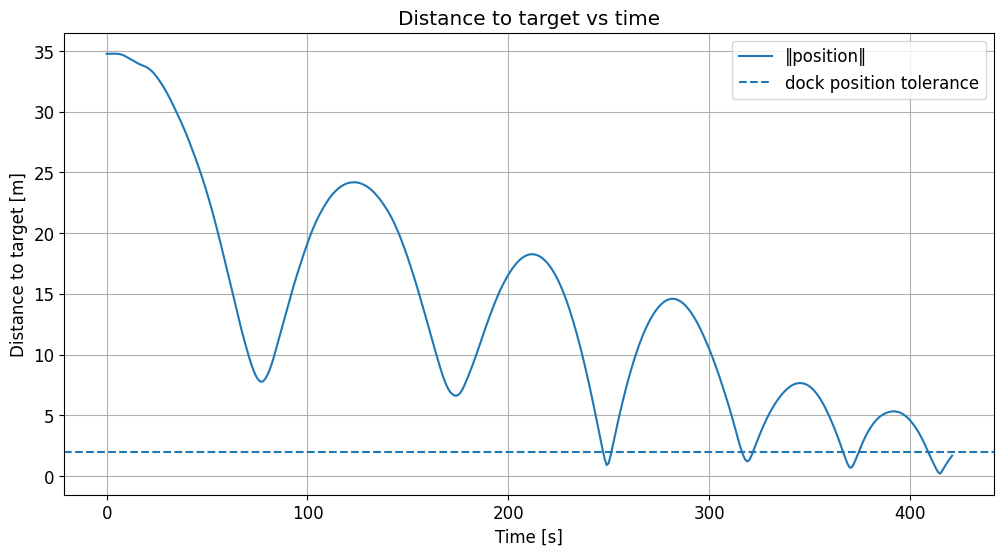

In [23]:
# plot 2 – distance to target vs time (with docking tolerance)
pos_norm = metrics["pos_norm"][:dock_step]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, pos_norm, label="‖position‖")
ax.axhline(dock_pos_tol, linestyle="--", label="dock position tolerance")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance to target [m]")
ax.set_title("Distance to target vs time")
ax.legend()
ax.grid(True)
plt.show()

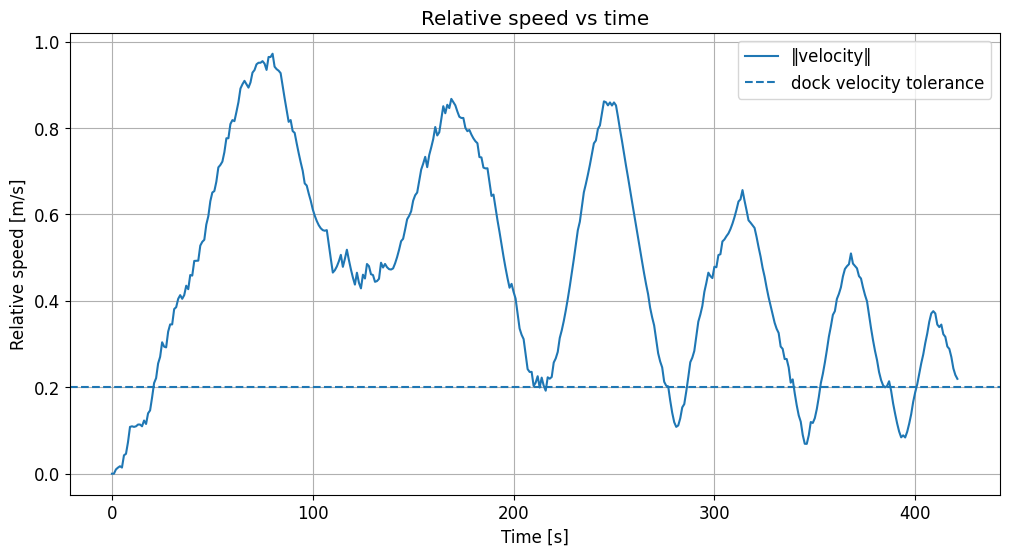

In [24]:
# plot 3 – velocity norm vs time (with docking tolerance)
vel_norm = metrics["vel_norm"][:dock_step]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, vel_norm, label="‖velocity‖")
ax.axhline(dock_vel_tol, linestyle="--", label="dock velocity tolerance")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Relative speed [m/s]")
ax.set_title("Relative speed vs time")
ax.legend()
ax.grid(True)
plt.show()

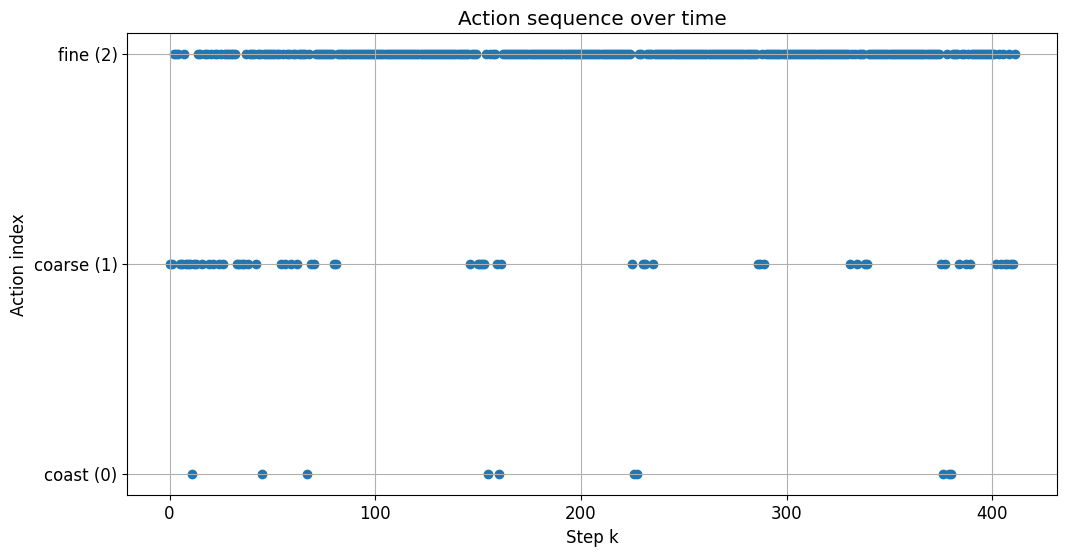

In [83]:
# plot 4 – action sequence vs time
# actions: 0 = coast, 1 = fine thrust, 2 = coarse thrust

# fig, ax = plt.subplots(figsize=(12,6))
# ax.step(np.arange(len(actions)), actions, where="post")
# ax.set_xlabel("Step k")
# ax.set_ylabel("Action index")
# ax.set_title("Action sequence over time")
# ax.set_yticks(np.arange(13))
# ax.set_yticklabels(["coast (0)", 
#                     "coarse +x (1)", 
#                     "coarse -x (2)", 
#                     "coarse +y (3)", 
#                     "coarse -y (4)", 
#                     "coarse +z (5)", 
#                     "coarse -z (6)", 
#                     "fine +x (7)", 
#                     "fine -x (8)", 
#                     "fine +y (9)", 
#                     "fine -y (10)", 
#                     "fine +z (11)", 
#                     "fine -z (12)", 
#                     ])
# ax.grid(True)
# plt.show()

# plot 4 – action sequence vs time
# actions: 0 = coast, 1 = fine thrust, 2 = coarse thrust

actions_shaved = [
    0 if a == 0 
    else 1 if (a < 7)
    else 2
    for a in actions
]
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(np.arange(len(actions)), actions_shaved)
ax.set_xlabel("Step k")
ax.set_ylabel("Action index")
ax.set_title("Action sequence over time")
ax.set_yticks(np.arange(3))
ax.set_yticklabels(["coast (0)", 
                    "coarse (1)", 
                    "fine (2)",
                    ])
ax.grid(True)
plt.show()

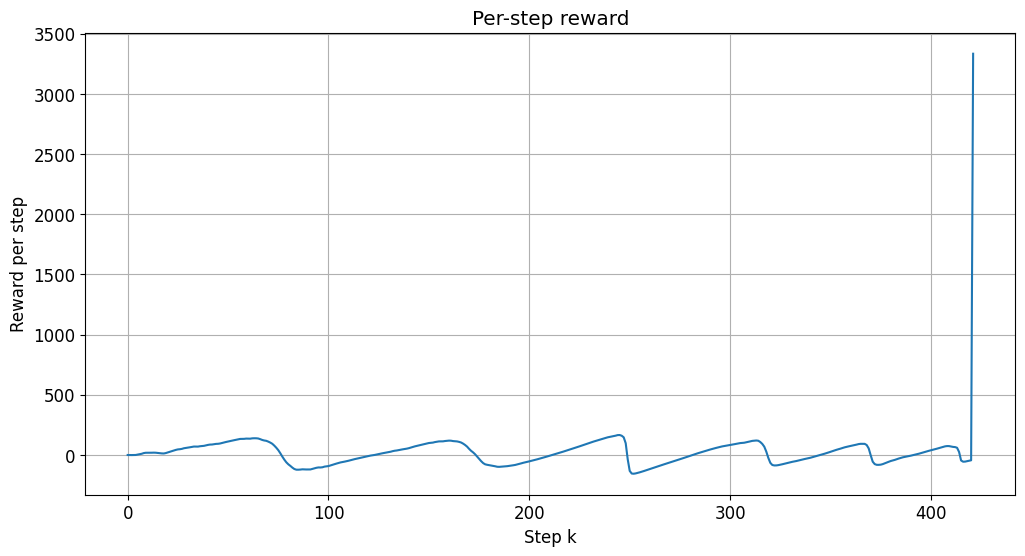

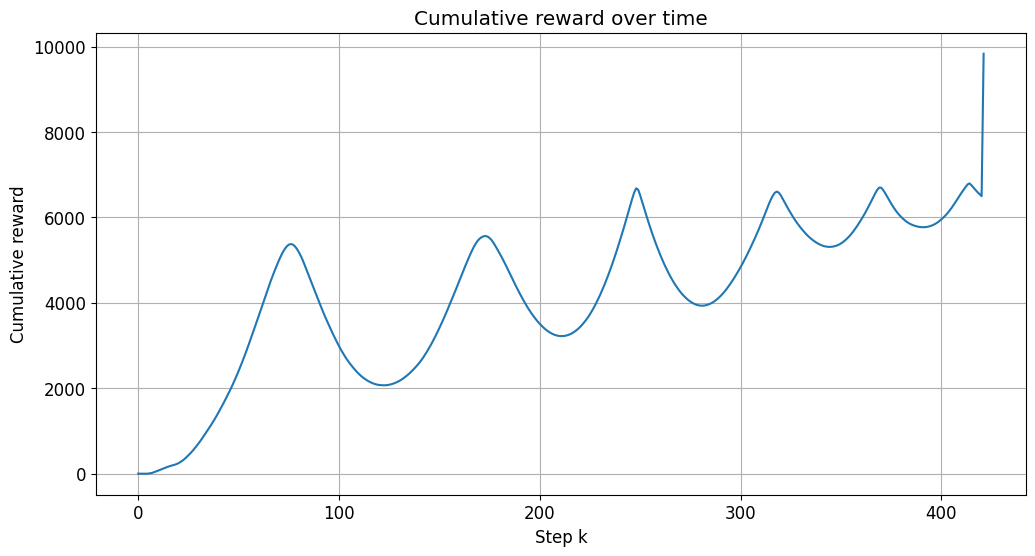

In [26]:
# lot 5 – per-step reward and cumulative reward
cum_reward = metrics["cum_reward"][:dock_step]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(len(rewards)), rewards)
ax.set_xlabel("Step k")
ax.set_ylabel("Reward per step")
ax.set_title("Per-step reward")
ax.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(len(cum_reward)), cum_reward)
ax.set_xlabel("Step k")
ax.set_ylabel("Cumulative reward")
ax.set_title("Cumulative reward over time")
ax.grid(True)
plt.show()

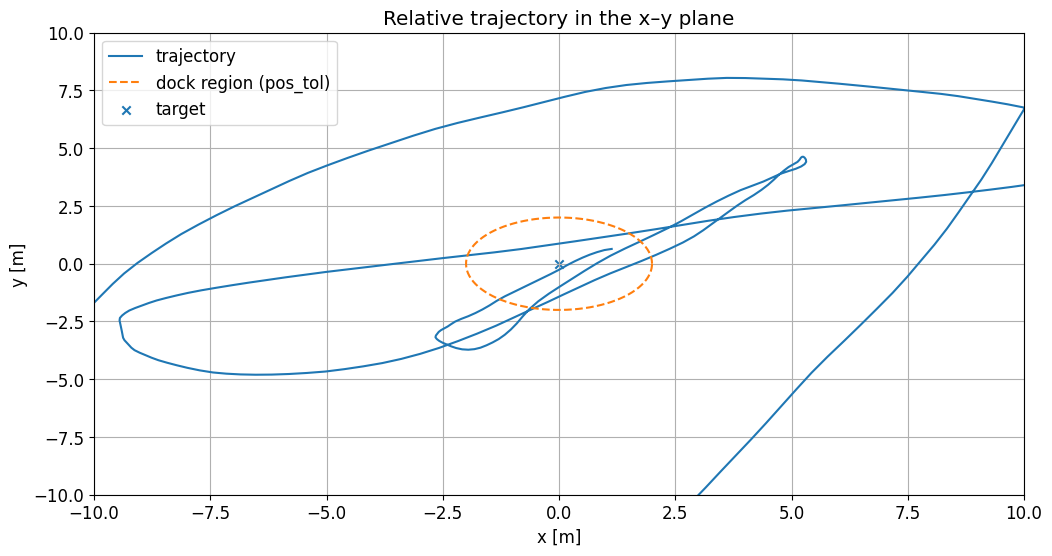

In [27]:
# plot 6 – 2D trajectory in x–y with docking region
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(X_true[:, 0], X_true[:, 1], label="trajectory")

# draw docking circle in x–y plane (z ignored)
theta = np.linspace(0, 2 * np.pi, 200)
ax.plot(dock_pos_tol * np.cos(theta),
        dock_pos_tol * np.sin(theta),
        linestyle="--",
        label="dock region (pos_tol)")

ax.scatter([0.0], [0.0], marker="x", label="target")
# ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_xlim((-10,10))
ax.set_ylim((-10,10))
# ax.set_ylabel("y [m]")
ax.set_title("Relative trajectory in the x–y plane")
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
# plot orbits 
fig = go.Figure()

# Satellite path
fig.add_scatter3d(
    x=X_true[:, 0],
    y=X_true[:, 1],
    z=X_true[:, 2],
    mode="lines",
    showlegend=False
)

# Sphere for docking tolerance box
color1 = 'blue'
color2 = 'red'
fig.add_surface(x=x_coords, y=y_coords, z=z_coords, colorscale=[[0, color1], [1,color1]], opacity=0.3)

fig.update_layout(showlegend=False, width=1000, height=800,
  scene=dict(
    xaxis=dict(title="X [m]"),
    yaxis=dict(title="Y [m]"),
    zaxis=dict(title="Z [m]"),
  ),
)

fig.show()

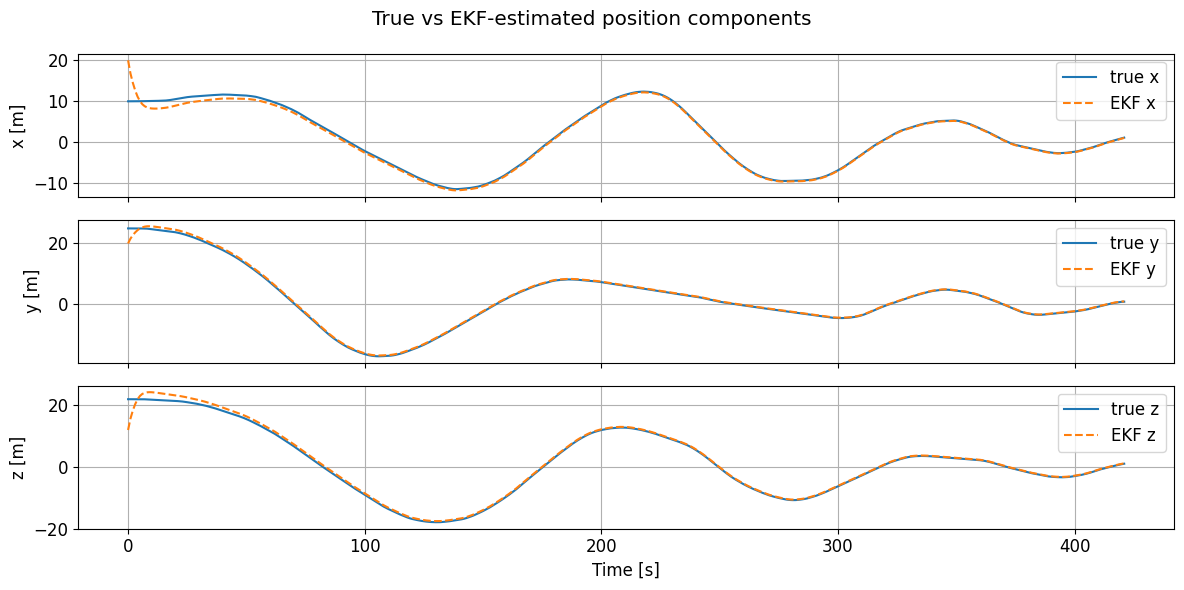

In [30]:
# plot 7 – true vs estimated position (EKF performance)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,6))

labels = ["x", "y", "z"]
for i in range(3):
    axs[i].plot(t, X_true[:, i], label=f"true {labels[i]}")
    axs[i].plot(t, X_hat[:, i], linestyle="--", label=f"EKF {labels[i]}")
    axs[i].set_ylabel(f"{labels[i]} [m]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
fig.suptitle("True vs EKF-estimated position components")
plt.tight_layout()
plt.show()

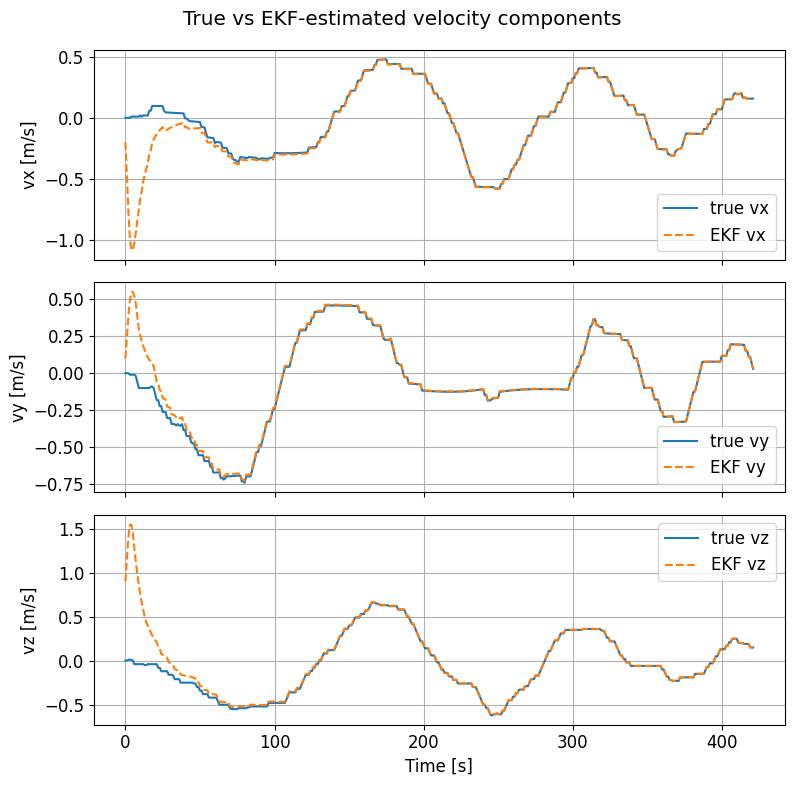

In [31]:
# plot 8 – true vs estimated velocity (EKF performance)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

labels = ["vx", "vy", "vz"]
for i in range(3):
    axs[i].plot(t, X_true[:, 3 + i], label=f"true {labels[i]}")
    axs[i].plot(t, X_hat[:, 3 + i], linestyle="--", label=f"EKF {labels[i]}")
    axs[i].set_ylabel(f"{labels[i]} [m/s]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
fig.suptitle("True vs EKF-estimated velocity components")
plt.tight_layout()
plt.show()

# Multiple Runs

## Setup

In [13]:
# Each config can have multiple seeds, and each seed corresponds to a run
@dataclass
class Config:
    config_dict: dict
    seeds: list[int]
    simulations: dict[int, dict] # Maps seed to a results simulation

# The results basically use configs as the "key" to a dictionary of that config's seeds/results
@dataclass
class Results:
    by_config: dict[str, Config] # config_hash to Config

In [14]:

# for sd, metric in zip(seed_list, all_metrics):

#     dock_step = metric["dock_step"]

#     if dock_step is None:
#         dock_step = CONFIG["N"]
#     t = np.arange(dock_step) * dt
#     # plot distance traces as "spaghetti" to show variability
#     plt.plot(t, metric["pos_norm"][:dock_step], alpha=0.7, label=f"seed {sd}")

# plt.axhline(dock_pos_tol, linestyle="--", label="dock pos tol")
# plt.xlabel("Time [s]")
# plt.ylabel("Distance to target [m]")
# plt.title("Distance vs time for multiple seeds")
# plt.legend()
# plt.grid(True)
# plt.show()

# # print a small table of summary metrics
# print("=== Summary over multiple seeds ===")
# for sd, m_sd in zip(seed_list, all_metrics):
#     print(f"Seed {sd}: final_dist = {m_sd['final_dist']:.2f} m, "
#           f"min_dist = {m_sd['min_dist']:.2f} m, "
#           f"total_reward = {m_sd['total_reward']:.1f}, "
#           f"docked = {m_sd['docked']}", end="")
#     if m_sd["docked"]:
#         print(f" at step {m_sd["dock_step"]}")
#     else:
#         print()

In [15]:
# experiment – run multiple seeds and compare
def run_seeds(start_seed, num_seeds): 
    seed_list = list(range(start_seed, start_seed + num_seeds))

    all_metrics = []

    for sd in seed_list:
        res_sd = run_closed_loop_episode(CONFIG, seed=sd, debug=False)
        m_sd = compute_metrics(res_sd, seed=sd)
        print_metrics(m_sd, title=f"Episode (seed={sd})")
        all_metrics.append(m_sd)

    with open("cache/results","rb") as f:
        all_results: Results = pickle.load(f)
        print(f"Loaded with {len(all_results.by_config)} configs")

    print(f"{len(all_results.by_config[config_hash].simulations.keys())}")
    for metric in all_metrics:
        seed = metric["seed"]
        all_results.by_config[config_hash].simulations[seed] = metric
    print(f"{len(all_results.by_config[config_hash].simulations.keys())}")

    with open("cache/results","wb") as f:
        pickle.dump(all_results, f)
        print(f"Saved with {len(all_results.by_config)} configs")

## Running Seeds

In [49]:
num = 1
for i in range(500,10000, num):
    print(f"Starting {num} at {i}")
    run_seeds(i,num)


Starting 1 at 500


NameError: name 'run_seeds' is not defined

## Analysis of runs

In [16]:
with open("cache/results","rb") as f:
    all_results: Results = pickle.load(f)
    print(f"Loaded with {len(all_results.by_config)} configs")

sims_dict = all_results.by_config[config_hash].simulations
num_sims = len(sims_dict)

Loaded with 1 configs


In [17]:
# Stat - Docking rate and reward metrics
sims_that_docked = [x for x in sims_dict.values() if x["docked"]]
sims_that_not_docked = [x for x in sims_dict.values() if not x["docked"]]

sims_that_docked_no_collisions = [x for x in sims_that_docked if not any(x["rewards"] < -4000)]
docking_rate = len(sims_that_docked) / num_sims
docking_rate_no_collisions = len(sims_that_docked_no_collisions) / num_sims
                    
print(f"Docking rate: {docking_rate * 100:.2f}%")
print(f"Docking rate if collisions stop the simulation: {docking_rate_no_collisions * 100:.2f}%")
print()

# Reward for docking
rewards_when_docking = [sim["cum_reward"] for sim in sims_that_docked]
rewards_when_no_docking = [sim["cum_reward"] for sim in sims_that_not_docked]

print(f"Average reward when successfully docked: {np.mean(rewards_when_docking):.2f}")
print(f"Average reward when not successfully docked: {np.mean(rewards_when_no_docking):.2f}")

Docking rate: 59.09%
Docking rate if collisions stop the simulation: 53.64%

Average reward when successfully docked: 4580.75
Average reward when not successfully docked: 2956.85


In [18]:
# Stat - Docking time metrics
docking_times = [x["dock_time"] for x in sims_that_docked_no_collisions]
print(f"{float(np.mean(docking_times)) =  }")
print(f"{float(np.median(docking_times)) =  }")
print(f"{float(np.std(docking_times)) =  }")
# plt.hist(docking_times, bins = 20)
# plt.xlim(left=0)

float(np.mean(docking_times)) =  505.10169491525426
float(np.median(docking_times)) =  507.0
float(np.std(docking_times)) =  61.31709605251787


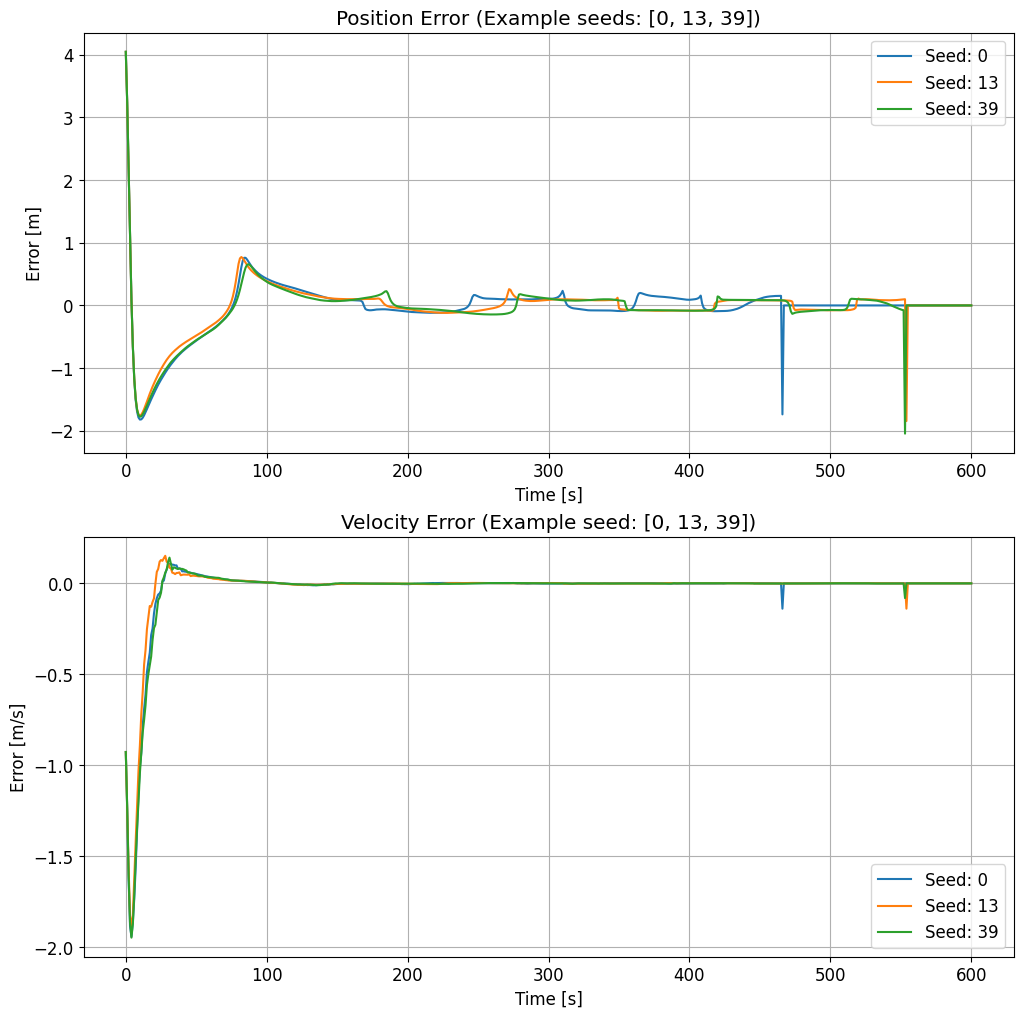

In [19]:
# Plot - Kalman Filter convergence (NOT USED)
positions = [np.linalg.norm(x["X_true"][:,:3], axis=1) for x in sims_that_docked_no_collisions]
position_estimates = [np.linalg.norm(x["X_hat"][:,:3], axis=1) for x in sims_that_docked_no_collisions]
velocities = [np.linalg.norm(x["X_true"][:,3:], axis=1) for x in sims_that_docked_no_collisions]
velocity_estimates = [np.linalg.norm(x["X_hat"][:,3:], axis=1) for x in sims_that_docked_no_collisions]

example_seeds = [0,13,39]
# example_seeds = [sims_that_docked_no_collisions[i]["seed"] for i in seeds]
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.title(f"Position Error (Example seeds: {example_seeds})")
for seed in example_seeds:
    plt.plot(positions[seed] - position_estimates[seed], label=f"Seed: {seed}")

plt.ylabel("Error [m]")
plt.xlabel("Time [s]")
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.title(f"Velocity Error (Example seed: {example_seeds})")
for seed in example_seeds:
    plt.plot(velocities[seed] - velocity_estimates[seed], label=f"Seed: {seed}")

plt.grid(True)
plt.ylabel("Error [m/s]")
plt.xlabel("Time [s]")
plt.legend()
plt.savefig("figures/pos_vel_error.png", dpi=300)
plt.show()


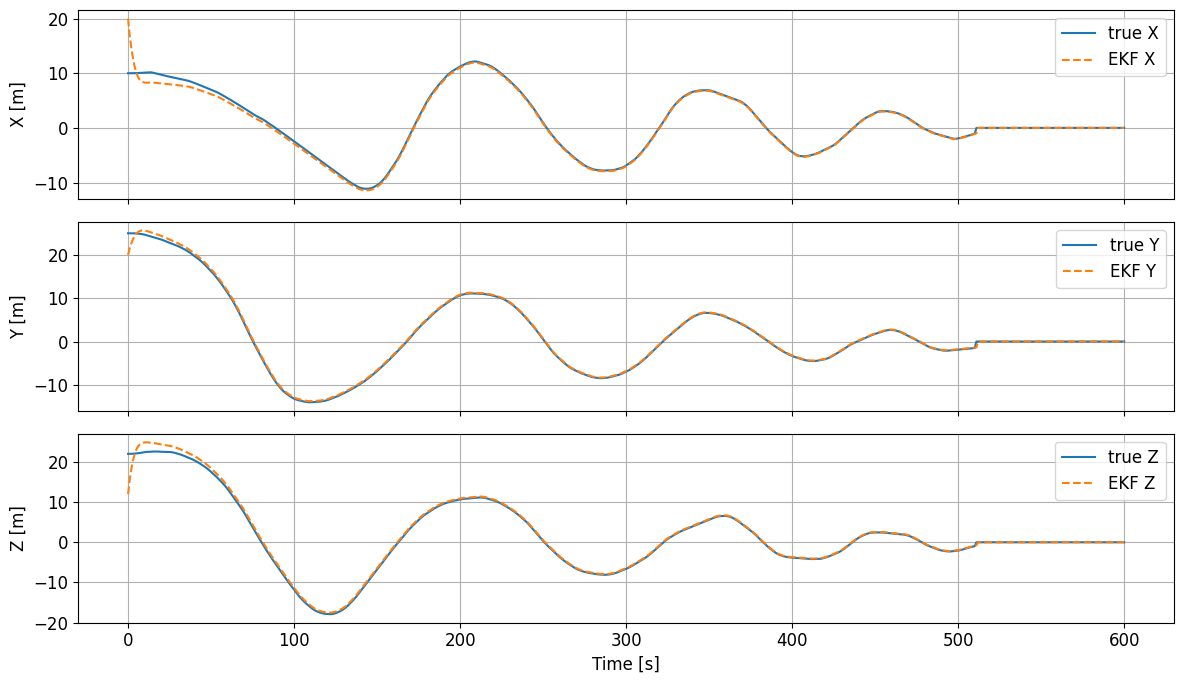

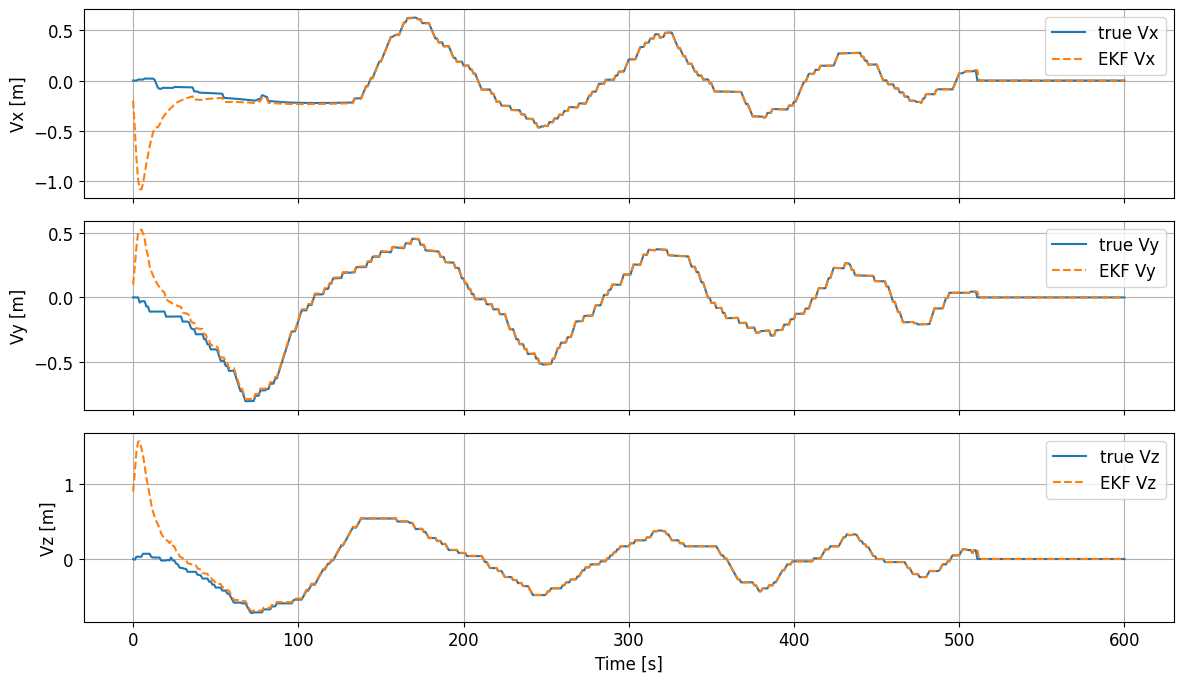

In [34]:
# Plot - True vs. Estimated Position of Seed 542
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7))

labels = ["X", "Y", "Z"]
pos = sims_that_docked_no_collisions[25]["X_true"]
pos_est = sims_that_docked_no_collisions[25]["X_hat"]

seed = sims_that_docked_no_collisions[25]["seed"]
for i in range(3):
    axs[i].plot(pos[:, i], label=f"true {labels[i]}")
    axs[i].plot(pos_est[:, i], linestyle="--", label=f"EKF {labels[i]}")
    axs[i].set_ylabel(f"{labels[i]} [m]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
# fig.suptitle(f"True vs EKF-estimated position components (example seed {seed})")
plt.tight_layout()
plt.savefig("figures/pos_error.png", dpi=300)
plt.show()

# plot 7 – true vs estimated position (EKF performance)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7))

labels = ["x", "y", "z"]

for i in range(3):
    axs[i].plot(pos[:, i+3], label=f"true V{labels[i]}")
    axs[i].plot(pos_est[:, i+3], linestyle="--", label=f"EKF V{labels[i]}")
    axs[i].set_ylabel(f"V{labels[i]} [m]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
# fig.suptitle(f"True vs EKF-estimated velocity components (example seed {seed})")
plt.tight_layout()
plt.savefig("figures/vel_error.png", dpi=300)
plt.show()

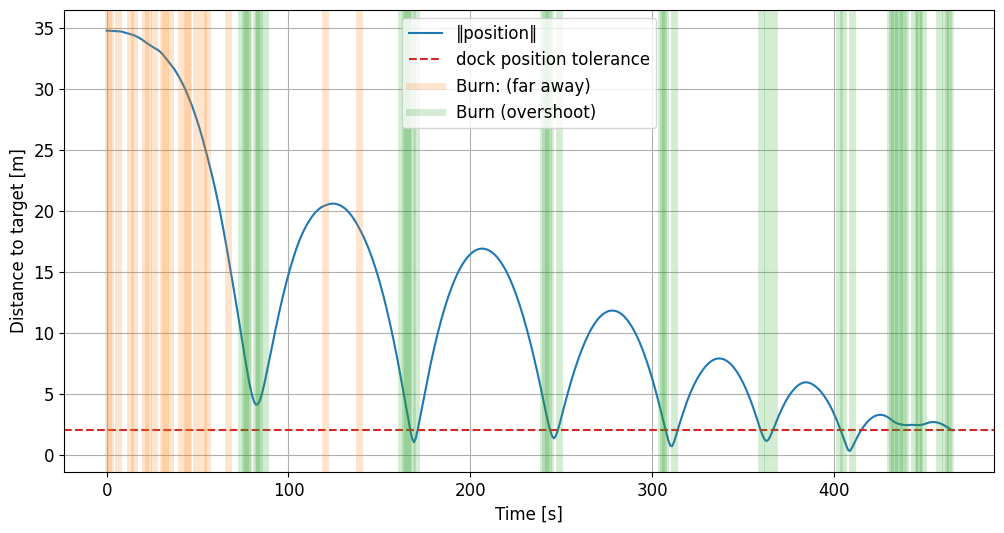

In [35]:
# Plot - Distance to target (with docking tolerance and coarse burns)
sim = sims_that_docked[0]
pos_norm = sim["pos_norm"]
dock_step = sim["dock_step"]


fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pos_norm[:dock_step], label="‖position‖")
ax.axhline(dock_pos_tol, linestyle="--", color="tab:red", label="dock position tolerance")

first_step_already = False
for t_step, action in enumerate(sim["actions"]):
    if action in np.arange(1,7) and pos_norm[t_step] > 15: #1-6

        if not first_step_already:
            ax.axvline(t_step, color="tab:orange", linewidth=5, alpha=0.2, label="Burn: (far away)")    
            first_step_already = True
        else:
            ax.axvline(t_step, color="tab:orange", linewidth=5, alpha=0.2)    

first_step_already = False
for t_step, action in enumerate(sim["actions"]):
    if action in np.arange(1,7) and pos_norm[t_step] < 15: #1-6

        if not first_step_already:
            ax.axvline(t_step, color="tab:green", linewidth=5, alpha=0.2, label="Burn (overshoot)")   
            first_step_already = True
        else:
            ax.axvline(t_step, color="tab:green", linewidth=5, alpha=0.2)   
            


# ax.legend(( "From far away", "From overshoot"))
ax.legend()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance to target [m]")
# ax.set_title("Coarse burns over time")
ax.grid(True)
plt.savefig("figures/coarse_burns.png", dpi=300)
plt.show()

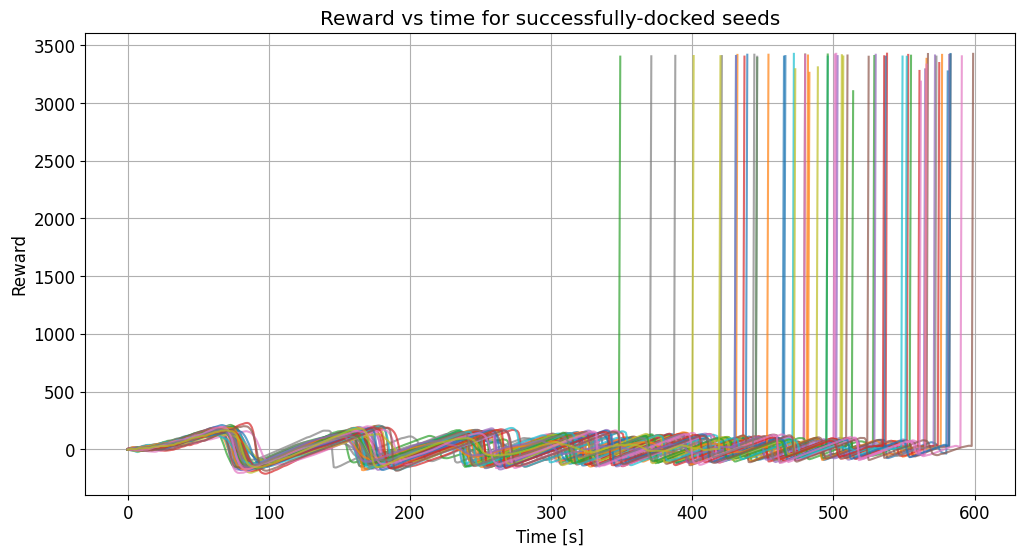

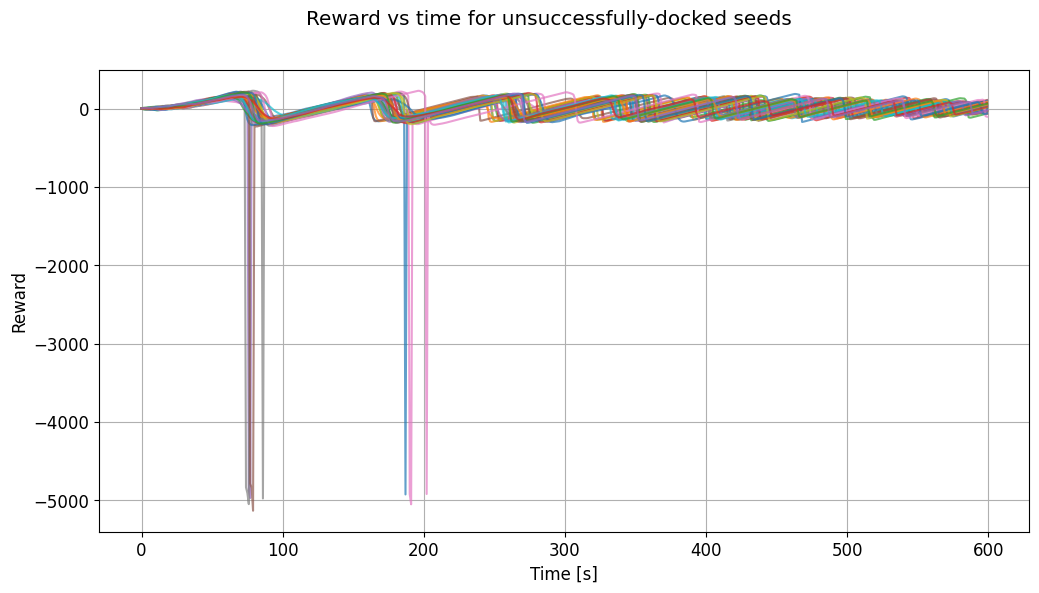

In [22]:
# Plot - Rewards vs. time for success and failure
fig, ax = plt.subplots(figsize=(12,6))
for sim in sims_that_docked_no_collisions:

    dock_step = sim["dock_step"]

    if dock_step is None:
        dock_step = CONFIG["N"]
    t = np.arange(dock_step) * dt
    # plot distance traces as "spaghetti" to show variability
    ax.plot(t, sim["rewards"][:dock_step], alpha=0.7)

ax.set_xlabel("Time [s]")
ax.set_ylabel("Reward")
ax.set_title("Reward vs time for successfully-docked seeds")
# ax.legend()
ax.grid(True)
plt.show()


fig, ax = plt.subplots(figsize=(12,6))
for sim in sims_that_not_docked:

    dock_step = sim["dock_step"]

    if dock_step is None:
        dock_step = CONFIG["N"]
    t = np.arange(dock_step) * dt
    # plot distance traces as "spaghetti" to show variability
    ax.plot(t, sim["rewards"][:dock_step], alpha=0.7)

ax.set_xlabel("Time [s]")
ax.set_ylabel("Reward")
fig.suptitle("Reward vs time for unsuccessfully-docked seeds")
# ax.legend()
ax.grid(True)
plt.show()


In [23]:
# Stat - mass of satellites that docked vs. didn't
successful_masses = []
for sat in sims_that_docked_no_collisions:
    m = 500
    for action in sat["actions"]:
        if action in np.arange(1,7):
            m -= 4
        elif action in np.arange(7,12):
            m -= 0.5

    successful_masses.append(m)
    
# plt.plot(successful_masses)
# plt.show()

unsuccessful_masses = []
for sat in sims_that_not_docked:
    m = 500
    for action in sat["actions"]:
        if action in np.arange(1,7):
            m -= 4
        elif action in np.arange(7,12):
            m -= 0.5

    unsuccessful_masses.append(m)
    
# plt.plot(unsuccessful_masses)
# plt.show()


print(f"Average final mass of docked satellites: {np.mean(successful_masses)}")
print(f"Average final mass of non-docked satellites: {np.mean(unsuccessful_masses)}")


Average final mass of docked satellites: 77.34745762711864
Average final mass of non-docked satellites: 58.06666666666667


In [30]:
# 3D Plot - paths
fig = go.Figure()

# Satellite paths
for run in list(sims_dict.values())[6:7]:
    print(run["seed"])
    fig.add_scatter3d(
        x=run["X_true"][:, 0],
        y=run["X_true"][:, 1],
        z=run["X_true"][:, 2],
        mode="lines",
        showlegend=False
    )

# Sphere for docking tolerance box
color1 = 'blue'
color2 = 'red'
fig.add_surface(x=x_coords, y=y_coords, z=z_coords, colorscale=[[0, color1], [1,color1]], opacity=0.3)

fig.update_layout(showlegend=False, width=1000, height=800,
  scene=dict(
    xaxis=dict(title="X [m]"),
    yaxis=dict(title="Y [m]"),
    zaxis=dict(title="Z [m]"),
  ),
)
# fig.write_image("figures/3D.png", default_scale=10)
# with open("figures/3D.png", "wb") as f:
#     f.write(fig.to_image(format="png", dpi=300))
fig.show()

505
